导入相关包

In [1]:
import pandas as pd 
import numpy as np
import os 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import csv
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

数据预处理，要注意的是训练集和测试集进行独热编码之后可能形状不一样，所以要将他们进行配对；再者是因为我们要给缺失某列的数据进行增加全为零的列，奇怪的是当从DataFrame类型转到Numpy类型时全为零的列会全部变成nan，所以还要重新nan的列转成零。否则在预测的过程网络的输出会全部为nan。本次实验将训练集进行2 : 9的数据划分，2份作为验证集。

In [2]:
def add_missing_columns(d, columns) :
    missing_col = set(columns) - set(d.columns)
    for col in missing_col :
        d[col] = 0
        
def fix_columns(d, columns):  
    add_missing_columns(d, columns)
    assert(set(columns) - set(d.columns) == set())
    d = d[columns]
    return d

def data_process(df, model) :
    df.replace(" ?", pd.NaT, inplace = True)
    if model == 'train' :
        df.replace(" >50K", 1, inplace = True)
        df.replace(" <=50K", 0, inplace = True)
    if model == 'test':
        df.replace(" >50K.", 1, inplace = True)
        df.replace(" <=50K.", 0, inplace = True)
        
    trans = {'workclass' : df['workclass'].mode()[0], 'occupation' : df['occupation'].mode()[0], 'native-country' : df['native-country'].mode()[0]}
    df.fillna(trans, inplace = True)
    df.drop('fnlwgt', axis = 1, inplace = True)
    df.drop('capital-gain', axis = 1, inplace = True)
    df.drop('capital-loss', axis = 1, inplace = True)

    df_object_col = [col for col in df.columns if df[col].dtype.name == 'object']
    df_int_col = [col for col in df.columns if df[col].dtype.name != 'object' and col != 'income']
    target = df["income"]
    dataset = pd.concat([df[df_int_col], pd.get_dummies(df[df_object_col])], axis = 1)

    return target, dataset
        

class Adult_data(Dataset) :
    def __init__(self, model) :
        super(Adult_data, self).__init__()
        self.model = model
        
        df_train = pd.read_csv('adult.csv', header = None, names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',  'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])
        df_test = pd.read_csv('data.test', header = None, skiprows = 1, names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',  'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'])
        
        train_target, train_dataset = data_process(df_train, 'train')
        test_target, test_dataset = data_process(df_test, 'test')
        
#         进行独热编码对齐
        test_dataset = fix_columns(test_dataset, train_dataset.columns)
#         print(df["income"])
        train_dataset = train_dataset.apply(lambda x : (x - x.mean()) / x.std())
        test_dataset = test_dataset.apply(lambda x : (x - x.mean()) / x.std())
#         print(train_dataset['native-country_ Holand-Netherlands'])
        
        train_target, test_target = np.array(train_target), np.array(test_target)
        train_dataset, test_dataset = np.array(train_dataset, dtype = np.float32), np.array(test_dataset, dtype = np.float32)
        if model == 'test' :
            isnan = np.isnan(test_dataset)
            test_dataset[np.where(isnan)] = 0.0
#             print(test_dataset[ : , 75])
        
        if model == 'test':
            self.target = torch.tensor(test_target, dtype = torch.int64)
            self.dataset = torch.FloatTensor(test_dataset)
        else :
#           前百分之八十的数据作为训练集，其余作为验证集
            if model == 'train' : 
                self.target = torch.tensor(train_target, dtype = torch.int64)[ : int(len(train_dataset) * 0.8)]
                self.dataset = torch.FloatTensor(train_dataset)[ : int(len(train_target) * 0.8)]
            else :
                self.target = torch.tensor(train_target, dtype = torch.int64)[int(len(train_target) * 0.8) : ] 
                self.dataset = torch.FloatTensor(train_dataset)[int(len(train_dataset) * 0.8) : ]
        print(self.dataset.shape, self.target.dtype)   
        
    def __getitem__(self, item) :
        return self.dataset[item], self.target[item]
    
    def __len__(self) :
        return len(self.dataset)
    
train_dataset = Adult_data(model = 'train')
val_dataset = Adult_data(model = 'val')
test_dataset = Adult_data(model = 'test')

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, drop_last = False)

torch.Size([26048, 102]) torch.int64
torch.Size([6513, 102]) torch.int64
torch.Size([16281, 102]) torch.int64


构建网络，因为是简单的二分类，这里使用了两层感知机网络，后面做对结果进行softmax归一化。

In [3]:
class Adult_Model(nn.Module) :
    def __init__(self) :
        super(Adult_Model, self).__init__()
        self.net = nn.Sequential(nn.Linear(102, 64), 
                                nn.ReLU(), 
                                nn.Linear(64, 32), 
                                nn.ReLU(),
                                nn.Linear(32, 2)
                                )
    def forward(self, x) :
        out = self.net(x) 
#         print(out)
        return F.softmax(out)

训练及验证，每经过一个epoch，就进行一次损失比较，当val_loss更小时，保存模型，直至迭代结束。

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = Adult_Model().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
criterion = nn.CrossEntropyLoss()
max_epoch = 30
classes = [' <=50K', ' >50K']
mse_loss = 1000000
os.makedirs('MyModels', exist_ok = True)
writer = SummaryWriter(log_dir = 'logs')


for epoch in range(max_epoch) :
    
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for x, label in train_loader :
        x, label = x.to(device), label.to(device)
        optimizer.zero_grad()
        
        out = model(x)
        loss = criterion(out, label)
        train_loss += loss.item()
        loss.backward()
        
        _, pred = torch.max(out, 1)
#         print(pred)
        num_correct = (pred == label).sum().item()
        acc = num_correct / x.shape[0]
        train_acc += acc
        optimizer.step()
        
    print(f'epoch : {epoch + 1}, train_loss : {train_loss / len(train_loader.dataset)}, train_acc : {train_acc / len(train_loader)}')
    writer.add_scalar('train_loss', train_loss / len(train_loader.dataset), epoch)
    
    with torch.no_grad() :
        total_loss = []
        model.eval()
        for x, label in val_loader :
            x, label = x.to(device), label.to(device)
            out = model(x)
            loss = criterion(out, label)
            total_loss.append(loss.item())
        
        val_loss = sum(total_loss) / len(total_loss)
    
    if val_loss < mse_loss :
        mse_loss = val_loss 
        torch.save(model.state_dict(), 'MyModels/Deeplearning_Model.pth')

del model

<ipython-input-3-34906da3126c>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


epoch : 1, train_loss : 0.009698766862621179, train_acc : 0.7546068796068796
epoch : 2, train_loss : 0.008849774435830716, train_acc : 0.7604038697788698
epoch : 3, train_loss : 0.008572402777475207, train_acc : 0.7604038697788698
epoch : 4, train_loss : 0.00841165453090312, train_acc : 0.7604038697788698
epoch : 5, train_loss : 0.008271820490827432, train_acc : 0.7604038697788698
epoch : 6, train_loss : 0.008132823367651176, train_acc : 0.7604038697788698
epoch : 7, train_loss : 0.007982730547410118, train_acc : 0.7605958230958231
epoch : 8, train_loss : 0.007808244138434346, train_acc : 0.7963375307125307
epoch : 9, train_loss : 0.007641532746685957, train_acc : 0.8250153562653563
epoch : 10, train_loss : 0.0075265988364303146, train_acc : 0.8296990171990172
epoch : 11, train_loss : 0.0074580969227162125, train_acc : 0.8308891277641277
epoch : 12, train_loss : 0.007414823630252619, train_acc : 0.8321560196560197
epoch : 13, train_loss : 0.00738567921289538, train_acc : 0.832923832923

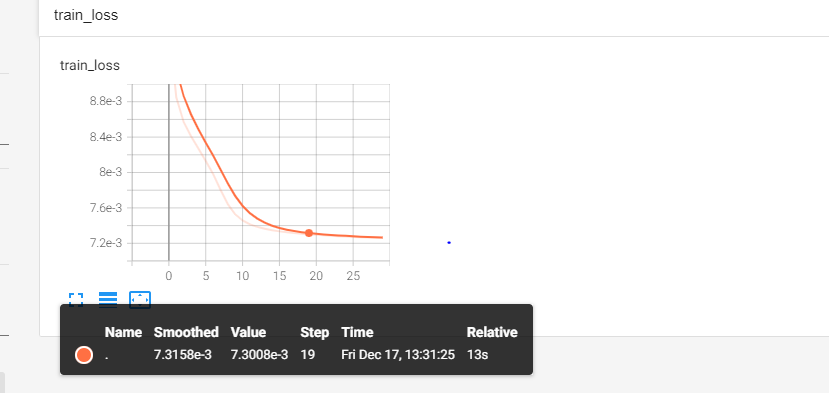

预测并保存结果

In [5]:
best_model = Adult_Model().to(device)
ckpt = torch.load('MyModels/Deeplearning_Model.pth', map_location='cpu')
best_model.load_state_dict(ckpt)

test_loss = 0.0
test_acc = 0.0
best_model.eval()
result = []

for x, label in test_loader :
    x, label = x.to(device), label.to(device)
    
    out = best_model(x)
    loss = criterion(out, label)
    test_loss += loss.item()
    _, pred = torch.max(out, dim = 1)
    result.append(pred.detach())
    num_correct = (pred == label).sum().item()
    acc = num_correct / x.shape[0]
    test_acc += acc

print(f'test_loss : {test_loss / len(test_loader.dataset)}, test_acc : {test_acc / len(test_loader)}')

result = torch.cat(result, dim = 0).cpu().numpy()
with open('Predict/Deeplearing.csv', 'w', newline = '') as file :
    writer = csv.writer(file)
    writer.writerow(['id', 'pred_result'])
    for i, pred in enumerate(result) :
        writer.writerow([i, classes[pred]])

<ipython-input-3-34906da3126c>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(out)


test_loss : 0.007335228695490753, test_acc : 0.8346127450980392


预测正确率能够达到83%，如果能再调一些参数，正确率会提高的